<a href="https://colab.research.google.com/github/diegorusso/deep-learning-from-scratch/blob/master/08_model_optimizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Optimizations

There is an entire spectrum of processor types that can be used as inference engines for edge computing. There are trade-offs to make depending the processor we use.

A typical case is: a Cortex-M being used key word spotting and then a Cortex-A for speech recognition.

More capable **CPUs or GPUs then are not used for inference in mobile devices** because they are not so power-efficient compared to microcontrollers and custom accellerators

Here below a workflow that show the flow from training a model to make the inference at the edge.

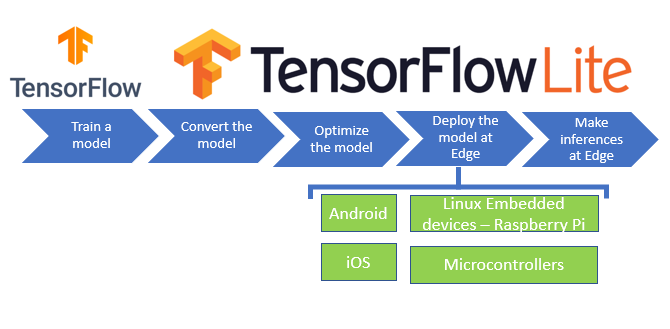

**Training** is done using one of the popular open-source framework (TensorFlow or Caffe).

Each processor vendor though provides their own back-end flow from trained network through silicon. **There is very little standardization.**
So a **conversion step** is needed between the trained network in TF and the format required by the processor vendor.

To deploy the model at the edge it is critical **to reduce the memory footprint** for the ML application. The goal is to **fit all the weights in memory** on the embedded device in order to avoid fethches from storage which are not power efficient (and slow).

There are mainly 2 techniques:
* **pruning**: setting any near-zero weights to zero, reducing the size of the weight table by allowing it to be compressed
* **quantization**: replacing the 32-bit floating-point arithmetic used for training the neural network with lower precision arithmetic, commonly 8-bit integer arithmetic.

After this optimization step, we can deploy our model at the edge.

Let's see those techniques in details.

## Network Pruning

It is possible to reduce the number of connections in a neural network significantly (up to 90%!) with no or very little of accuracy loss.

These are the high level steps:
1. Train the network
2. Remove all connections with weight < threshold
3. Fine-tune the weights retraining the network

The third step is needed in order to preserve the original accuracy otherwise the accuracy loss would be too high.

The above steps could be **iterate multiple times** in order to reduce more the size of the network.

With pruned connections, the weights can be stored in a **sparse matrix** reducing the amount of memory needed to store the weights.

To have an idea how to prune a model with TF and MO, please see the public example mad by google: https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/pruning/pruning_with_keras.ipynb 


## Quantization

When **training** a neural network **all weights, biases and activations are typically 32-bit floating point numbers**. Precision is needed and the 32-bit dynamic range performs well when running the gradient update. So here, we are talking about **training**.

When we need to deploy the network on the target system for **inference**, the 32-bit floating point arithmetic typically uses too much memory, hardware and power.

One solution is to **quantize the weights, biases and activations** to use small integer or fixed-point values. **8-bit values** are typically chosen.
The whole flow can be automated and there are research going on to use also 1-bit weights.

There is also **fake quantization**: during **training we restrict the values of the 32-bit floating point weights, biases and activations to the quantized values** even though these values are actually represented in 32 bits. Gradients and back-propagation can still be performed using 32-bit precision. This often gives a very significant improvement to the point where the results are often almost as good as the full-precision network





**8-bit quantization seems to be a good, practical compromise** between saving memory and power on the one hand and retaining accuracy and robustness on the other.

8-bit quantization typically works
* choosing precise floating point values for the minimum and maximum values that are to be represented
* 256 separate floating point values are then chosen, distributed uniformly across the range from minimum to maximum 
* can be asymmetrical about zero but for deep learning the zero needs to be included in the range
* min/max can be slightly adjusted to ensure floating point zero is exactly respresented

If you are an end user of deep learning technology as opposed to a researcher, quantization would be done by running a **proprietary software** tool provided by your processor vendor.

Tensorflow though offers a built-in script to perform 8-bit quantization.

**Pruning and quantization can be combined** in order to achieve high compression without losing accuracy. An example could be
1. Pruning: setting near-zero weights to zero
2. Re-training: with sparse weight matrix
3. Quantization: replace 32-bit floats with 8-bit integers
4. Compression: store weight matrix in compressed format

The above workflow might achieve **10x compression** of the weight matrix.



To have a better idea on how to quantize a model with TensorFlow, please see the public examples made by Google: https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb

## Model optimization for targets

The final step is to **compile the pruned, quantized network to run on the target execution engine.**

The vendor will provide a flow that is able to make best use of the instruction set of the target processor.

The vendor may also be able to take advantage of so-called operation fusing in which several basic instructions (usually arithmetic instructions) are combined into a single specialist neural network instruction.

An example is **Vela**, an open source project made by Arm. It takes a tflite file as input and produces another optimized tflite as output. The optimized tflite file contains custom operators that are executed on the Arm Ethos-U. 

Vela can be found here https://review.mlplatform.org/plugins/gitiles/ml/ethos-u/ethos-u-vela and as Python package here https://pypi.org/project/ethos-u-vela/